In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%tensorflow_version 2
import tensorflow as tf
tf.__version__
# /content/gdrive/My Drive/Colab Notebooks/covid

99

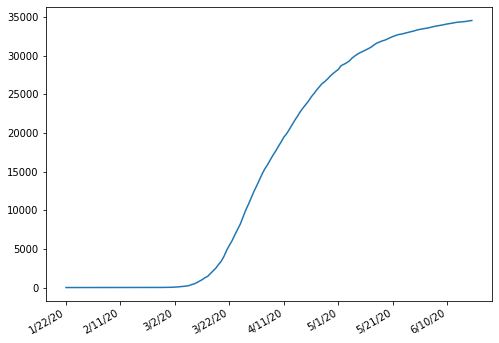

In [405]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

PATH = 'data/time_series_covid19_deaths_global.csv'  # get the full path to the file.
dataset = pd.read_csv(PATH)


TARGET_SIZE = 30

COUNTRY = 'Italy'
tf.random.set_seed(13)

dataset = dataset.transpose()

dataset = dataset.drop(["Province/State", "Lat", "Long", ], axis=0)

dataset.columns = dataset.iloc[0]

dataset.drop(dataset.index[[0]], inplace=True)

dataset = dataset[COUNTRY]

dataset.plot(subplots=True)

dataset.size

TRAIN_SPLIT = 99

TRAIN_SPLIT

In [406]:
dataset_mean = dataset[:TRAIN_SPLIT].mean()
dataset_std = dataset[:TRAIN_SPLIT].std()

In [407]:
# Let's standardize the data.
dataset = (dataset-dataset_mean)/dataset_std

In [408]:
def univariate_data_train(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  
  
  if (start_index and end_index):
    print("s: ", start_index)
    print("e: ", end_index)
    for i in range(start_index, end_index):
      # Reshape data first iter example: data index from 0 to 20 and label is index 21
      try:
        indices = list(range(i-history_size, i))
        data.append(list(dataset[i : (history_size+i) ]) )
        labels.append(dataset[history_size+i+target_size])

      except IndexError:
          break



  return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data_train(dataset, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
print("vals")
x_val_uni, y_val_uni = univariate_data_train(dataset, TRAIN_SPLIT, dataset.size,
                                       univariate_past_history,
                                       univariate_future_target)

In [367]:
print(x_train_uni.shape)
print(y_train_uni.shape)

[27359 27682 27967 28236 28710 28884 29079 29315 29684 29958 30201 30395
 30560 30739 30911 31106 31368 31610 31763 31908]
32007
[27682 27967 28236 28710 28884 29079 29315 29684 29958 30201 30395 30560
 30739 30911 31106 31368 31610 31763 31908 32007]
32169
(79, 20)
(79,)


In [410]:
x_val_uni = x_val_uni[:-1]

In [411]:
x_train_uni = np.reshape(x_train_uni, (79, 1, 20))
y_train_uni = np.reshape(y_train_uni, (79, 1))
x_val_uni = np.reshape(x_val_uni, (11, 1, 20))
y_val_uni = np.reshape(y_val_uni, (11, 1))

In [412]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(79, 1, 20)
(79, 1)
(11, 1, 20)
(11, 1)


In [413]:
BATCH_SIZE = 64

BUFFER_SIZE = int(x_train_uni.shape[0]/BATCH_SIZE)


train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [414]:
print(train_univariate)
print(train_univariate)
print(val_univariate)
print(val_univariate)

<RepeatDataset shapes: ((None, 1, 20), (None, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 1, 20), (None, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 1, 20), (None, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 1, 20), (None, 1)), types: (tf.float64, tf.float64)>


In [398]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)
print(simple_lstm_model.input_shape)

(79, 1, 20)
(79, 1)
(11, 1, 20)
(11, 1)
(None, 79, 20)


In [420]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [400]:
simple_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 928       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 937
Trainable params: 937
Non-trainable params: 0
_________________________________________________________________


In [421]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)                              

Epoch 1/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6722 - val_loss: 0.3472
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.1788 - val_loss: 0.1403
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0839 - val_loss: 0.1024
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0404 - val_loss: 0.0728
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0160 - val_loss: 0.0637
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0096 - val_loss: 0.0504
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0449
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0080 - val_loss: 0.0431
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0353
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 0.0078 - val_lo